In [1]:
# Step 1 – Import Necessary Libraries and Modules
 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df = pd.read_excel(r"C:\Users\jki\Downloads\Online Retail Dataset\Online Retail.xlsx")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [2]:
# check numerial values
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [3]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# check for missing values in each columns
missing_values = df.isnull().sum()
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [7]:
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'],inplace=True)

In [13]:
# Compute Reency ,Frequeny and Monetary  Value
# Lest start out by a reference date snapshot_date that a day later than the most recent date in the invoiceDate column
snapshot_date = max(df['InvoiceDate']) + pd.DateOffset(days=1)

# create a Total column that contains Quantity*Unit price for all the records
df['Total'] = df['Quantity'] * df['UnitPrice']


# This is how we calculate Recency , Frequency, and Monetary Value we calcuate as below grouped by Customer ID

# For Recency - we calculate the difference between the most recent purchase date and a reference date(snap_date ).This gives the number of days sicnce the customers last purchase .So smaller values inidcate that a customer has made purchase more recetly .But when we talk about recency socres.

# For Frequency - measures how often the customer makes a purchase .we will claculate it as total number of unique invoices or transactions made by each customer

# Monetary Values quantity how much money a customer spends .So we will find the average of the total monetary value across transcations

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total': 'sum'
})

# let rename the columns for readbility

rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','Total':'MonetaryValue'},inplace=True)
rfm.head()




,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [14]:
# Map the RFM Values onto a 1- 5 Scale

rfm.describe()



,Recency,Frequency,MonetaryValue
count,4372.000000,4372.000000,4372.000000
mean,92.047118,5.075480,1898.459701
std,100.765435,9.338754,8219.345141
min,1.000000,1.000000,-4287.630000
25%,17.000000,1.000000,293.362500
50%,50.000000,3.000000,648.075000
75%,143.000000,5.000000,1611.725000
max,374.000000,248.000000,279489.020000


In [21]:
# now lets map the Recency ,Frequency and Moentary  Values columns to take on values of 1-5 one of {1,2,3,5}

#we will  assign the vlaues of five differenct bins and map each bin to a vlaue

# this how we define custome bin edges

# calculate cusom bin edges for Recency , Frequency and Monetary scores
recency_bins = [rfm['Recency'].min()-1,20,50,150,250,rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() -1,2,3,10,100, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() -3,300,600,2000,5000,rfm['MonetaryValue'].max()]

# now lets have the bin edges lets map the scores to corresponding labels between 1 and 5 (both inclusive)

# calculate Recency score based on custom bins
rfm['R_Score'] = pd.cut(rfm['Recency'],bins=recency_bins,labels=range(1,6),include_lowest=True)

# Reverse the recency scores so that higher values inidicate more recent purchase
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# calcualte Frequency and Monetary scores based on custom bins

rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

# lets look as the first few rows of the R_Score ,R_Score and M_score columns

# Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(50))

            R_Score  F_Score  M_Score
CustomerID                           
12346.0           1        1        1
12347.0           5        3        4
12348.0           3        3        3
12349.0           5        1        3
12350.0           1        1        2
12352.0           4        4        3
12353.0           2        1        1
12354.0           2        1        3
12355.0           2        1        2
12356.0           4        2        4
12357.0           4        1        5
12358.0           5        1        3
12359.0           5        3        5
12360.0           3        2        4
12361.0           1        1        1
12362.0           5        4        5
12363.0           3        1        2
12364.0           5        3        3
12365.0           1        2        2
12367.0           5        1        1
12370.0           3        3        4
12371.0           4        1        3
12372.0           3        2        3
12373.0           1        1        2
12374.0     

In [23]:
#  set 6 - perform K-Means Clustering
# Lets extrac R, and M scores  to perfomr K-Means clustering
# Extract RFM scores for K-Means clustering
X = rfm[['R_Score','F_Score','M_Score']]


C:\Users\jki\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jki\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jki\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jki\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\jki\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(execu

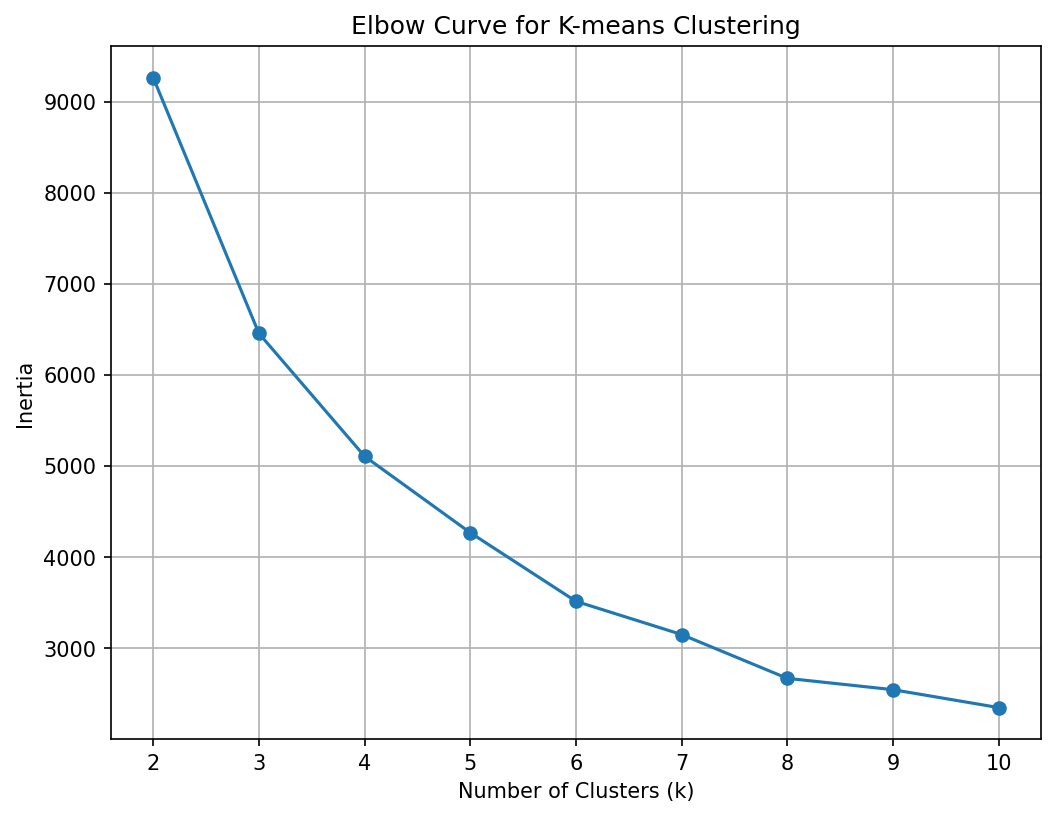

In [24]:
# next we need to find optimal number of clusters.for this lets run the Kmenss ,algorithm for range of K values and use the elbow method to pick the optimal K:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

In [25]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

In [26]:
# Interpret the clusters to identify customer segments
# Now that we have the clusters ,let try to characterize them based on the RFM scores
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()
 